# User Profile Bayesian Analysis

This notebook analyzes the results of the Bayesian analysis of the user profile data.

We split our Bayesian analyses into three steps:

1. Exploratory analysis of data + preparation for sampling (notebook)
2. Sampling (Python script)
3. Analysis of sampling results (notebook)

This is to enable the sampling process and its results to be managed and cached by DVC, and to avoid re-running the Bayesian sampling process when we only want to change how we look at its results.

## Setup

In [1]:
model = 'profile'

In [2]:
import os
from pathlib import Path

In [3]:
import pandas as pd
import numpy as np
import scipy.special as sps
from scipy import stats
import seaborn as sns
import plotnine as p
import matplotlib.pyplot as plt
from statsmodels.nonparametric.kde import KDEUnivariate
import zarr
from IPython.display import display, Markdown

In [4]:
from bookgender.config import rng_seed
from lenskit.util import init_rng
import bookgender.datatools as dt
from bookgender.nbutils import *

In [5]:
seed = init_rng(rng_seed(), 'ProfileModelAnalysis', propagate=True)
rng = np.random.default_rng(seed)
seed

SeedSequence(
    entropy=261868553827208103807548308384201786360,
    spawn_key=(2851018176,),
)

In [6]:
if model.startswith('profile'):
    fig_key = model
else:
    fig_key = 'profile-' + model
fig_key

'profile'

In [7]:
fig_dir = init_figs(f'PMA-{fig_key}')

using figure dir figures\PMA-profile


## Load Data

In [8]:
datasets = list(dt.datasets.keys())
datasets

['AZ', 'BX-E', 'BX-I', 'GR-E', 'GR-I']

We need to load the sampling results for each data set:

In [9]:
samples = {}
summary = {}
for ds in datasets:
    _zf = zarr.ZipStore(f'data/{ds}/inference/{model}/samples.zarr', mode='r')
    _c = zarr.LRUStoreCache(_zf, 2**30)
    samples[ds] = zarr.group(_c)
    summary[ds] = pd.read_csv(f'data/{ds}/inference/{model}-summary.csv', index_col='name')
summary = pd.concat(summary, names=['Set'])
summary.head()

Mean      MCSE     StdDev            5%           50%  \
Set name                                                                       
AZ  lp__      -38486.600000  1.205860  59.937900 -38585.400000 -38486.600000   
    mu            -0.514324  0.000239   0.030539     -0.564679     -0.514312   
    sigma          1.875070  0.000432   0.030105      1.825890      1.874820   
    nTheta[1]      1.054400  0.006098   0.927009     -0.392912      1.019800   
    nTheta[2]     -0.934858  0.003410   0.487180     -1.760500     -0.920706   

                        95%     N_Eff   N_Eff/s     R_hat  
Set name                                                   
AZ  lp__      -38389.500000   2470.63   7.02802  1.001160  
    mu            -0.464619  16390.50  46.62480  0.999683  
    sigma          1.925420   4846.20  13.78560  1.000050  
    nTheta[1]      2.638920  23110.10  65.73970  0.999805  
    nTheta[2]     -0.159354  20405.70  58.04650  0.999767

Extract and verify sample size:

In [10]:
sample_size = len(samples['AZ']['lp__'])
assert all(len(s['lp__']) == sample_size for s in samples.values())
sample_size

10000

## Quality Checks

Do we have parameters with bad mixing? (high $\hat{R}$)

In [11]:
summary.sort_values('R_hat', ascending=False).head()

Mean      MCSE    StdDev       5%      50%      95%  \
Set  name                                                                    
BX-E log_lik[4647] -1.64209  0.009218  0.514282 -2.68315 -1.44387 -1.26870   
GR-I log_lik[1010] -3.83992  0.011997  0.699917 -5.23830 -3.56766 -3.33978   
     log_lik[4433] -2.40830  0.012284  0.658181 -3.79130 -2.14496 -1.93683   
BX-I log_lik[360]  -2.12231  0.010487  0.598602 -3.32954 -1.89253 -1.70068   
GR-I log_lik[2111] -3.54390  0.015330  0.734541 -5.02787 -3.25711 -3.03061   

                      N_Eff   N_Eff/s    R_hat  
Set  name                                       
BX-E log_lik[4647]  3112.65   9.33244  1.00506  
GR-I log_lik[1010]  3403.51  10.82510  1.00484  
     log_lik[4433]  2870.91   9.13111  1.00481  
BX-I log_lik[360]   3257.91   9.59960  1.00471  
GR-I log_lik[2111]  2295.88   7.30219  1.00453

Let's compute LPPD and WAIC for each of our models:

In [12]:
def ll_stats(ds):
    ll_exp = samples[ds]['ll_exp']
    ll_var = samples[ds]['ll_var']
    lppd = np.sum(ll_exp)
    pwaic = np.sum(ll_var)
    return pd.Series({'lppd': lppd, 'pWAIC': pwaic, 'WAIC': -2 * (lppd - pwaic)})
pd.Series(datasets).apply(ll_stats).assign(Set=datasets).set_index('Set')

,lppd,pWAIC,WAIC
Set,,,
AZ,-6413.234228,2258.789672,17344.047799
BX-E,-8210.900013,2298.205891,21018.211808
BX-I,-8837.921196,2296.897944,22269.638279
GR-E,-11181.420201,2488.399088,27339.638579
GR-I,-12605.109108,2521.594828,30253.407871


## Extract and Summarize

Extract sample data in a form usable for plotting:

In [13]:
samp_df = pd.concat(dict((ds, pd.DataFrame({
    'Mu': samples[ds]['mu'],
    'Sigma': samples[ds]['sigma'],
    'Theta': samples[ds]['thetaP']
})) for ds in datasets), names=['Set']).copy()
samp_df

Mu    Sigma     Theta
Set                                   
AZ   0    -0.517427  1.89591  0.074957
     1    -0.549932  1.88656  0.195367
     2    -0.494122  1.86783  0.692173
     3    -0.558269  1.89490  0.170902
     4    -0.460593  1.86343  0.347322
...             ...      ...       ...
GR-I 9995 -0.277604  1.43525  0.055015
     9996 -0.256107  1.47247  0.337325
     9997 -0.258977  1.42790  0.602984
     9998 -0.249830  1.44898  0.621380
     9999 -0.257523  1.44148  0.880777

[50000 rows x 3 columns]

We also want to show observed distributions:

In [14]:
profiles = pd.read_pickle('data/profile-data.pkl')
profiles.head()

count  linked  ambiguous  male  female  dcknown  dcyes    PropDC  \
Set user                                                                     
AZ  529       8       8          2     1       4        8      3  0.375000   
    1723     25      24          3    15       6       25     14  0.560000   
    1810     14       6          0     6       0        8      1  0.125000   
    2781      8       8          1     5       1        8      5  0.625000   
    2863      6       6          0     6       0        6      4  0.666667   

          Known  PropFemale  PropKnown  
Set user                                
AZ  529       5    0.800000   0.625000  
    1723     21    0.285714   0.840000  
    1810      6    0.000000   0.428571  
    2781      6    0.166667   0.750000  
    2863      6    0.000000   1.000000

For each sample, we want to sample a predicted observation.  We do this by:

1. Sample $n'$ from the observed profile sizes
2. Sample $y' \sim \mathrm{Binomial}(n', \theta')$
3. Compute $y'/n'$

In [15]:
def _sample_ns(df):
    known = profiles.loc[df.name, 'Known']
    # return known.sample(len(df), replace=True).reset_index(drop=True)
    return pd.Series(rng.choice(known, len(df)))
samp_df.groupby('Set').apply(_sample_ns).stack()

Set       
AZ    0         6
      1         5
      2         9
      3         8
      4        22
             ... 
GR-I  9995    124
      9996     27
      9997    338
      9998     33
      9999     37
Length: 50000, dtype: int32

In [16]:
samp_df['N'] = samp_df.groupby('Set').apply(_sample_ns).stack()
samp_df['Y'] = rng.binomial(samp_df['N'], samp_df['Theta'], len(samp_df))
samp_df['PropFemale'] = samp_df['Y'] / samp_df['N']
samp_df.head()

Mu    Sigma     Theta   N   Y  PropFemale
Set                                                   
AZ  0 -0.517427  1.89591  0.074957   5   1    0.200000
    1 -0.549932  1.88656  0.195367  17   3    0.176471
    2 -0.494122  1.86783  0.692173  17  13    0.764706
    3 -0.558269  1.89490  0.170902  44   6    0.136364
    4 -0.460593  1.86343  0.347322  11   3    0.272727

## Summarize Statistics and Parameters

We want to report summary statistics of the various parameters.  We will start with observed ratios:

In [17]:
profiles.groupby('Set')['PropFemale'].agg(['mean', 'std']).T

Set,AZ,BX-E,BX-I,GR-E,GR-I
mean,0.414445,0.418886,0.407030,0.446998,0.450201
std,0.329436,0.267354,0.254304,0.276480,0.269127


In [18]:
print(profiles.groupby('Set')['PropFemale'].agg(['mean', 'std']).T.to_latex(float_format='%.3f'))

\begin{tabular}{lrrrrr}
\toprule
Set &    AZ &  BX-E &  BX-I &  GR-E &  GR-I \\
\midrule
mean & 0.414 & 0.419 & 0.407 & 0.447 & 0.450 \\
std  & 0.329 & 0.267 & 0.254 & 0.276 & 0.269 \\
\bottomrule
\end{tabular}



What about our est. mean log odds ($\mu$) and variance ($\sigma$)?  We also want to the posterior mean tendancy ($\theta$) and its variance.

It's important to distinguish between the *estimated variance of users* ($\sigma$) and the *variance of the estimate* (e.g. the variance of $\mu$). Since $\theta$ is a sample of a random unseen user, its variance should be comparable to the variance of the underlying users.

In [19]:
samp_df.groupby('Set')[['Mu', 'Sigma', 'Theta']].agg(['mean', 'std']).T

Set               AZ      BX-E      BX-I      GR-E      GR-I
Mu    mean -0.514324 -0.399788 -0.443699 -0.273188 -0.254082
      std   0.030539  0.019782  0.018357  0.022253  0.021304
Sigma mean  1.875065  1.185700  1.083546  1.498579  1.444677
      std   0.030105  0.018620  0.016934  0.018377  0.016772
Theta mean  0.422618  0.422504  0.412017  0.451731  0.452796
      std   0.300345  0.230205  0.214590  0.267270  0.261241

Find the 95% confidence intervals of $\mu$:

In [20]:
samp_df.groupby('Set')['Mu'].apply(lambda s: {
    'Low': s.quantile(0.025),
    'High': s.quantile(0.975)
}).unstack()

,Low,High
Set,,
AZ,-0.575250,-0.455224
BX-E,-0.439076,-0.361210
BX-I,-0.479702,-0.407404
GR-E,-0.316602,-0.229702
GR-I,-0.295727,-0.212234


Let's look at the STAN summary output for these parameters too:

In [21]:
summary.swaplevel().loc['mu', ['Mean', 'StdDev', '5%', '95%']].T

Set,AZ,BX-E,BX-I,GR-E,GR-I
Mean,-0.514324,-0.399788,-0.443699,-0.273188,-0.254082
StdDev,0.030539,0.019782,0.018357,0.022253,0.021304
5%,-0.564679,-0.432862,-0.473772,-0.309588,-0.288754
95%,-0.464619,-0.367577,-0.413480,-0.236570,-0.219111


In [22]:
summary.swaplevel().loc['sigma', ['Mean', 'StdDev', '5%', '95%']].T

Set,AZ,BX-E,BX-I,GR-E,GR-I
Mean,1.875070,1.185700,1.083550,1.498580,1.444680
StdDev,0.030105,0.018621,0.016934,0.018377,0.016772
5%,1.825890,1.155360,1.055850,1.468210,1.417360
95%,1.925420,1.216610,1.111790,1.529110,1.472570


In [23]:
summary.swaplevel().loc['thetaP', ['Mean', 'StdDev', '5%', '95%']].T

Set,AZ,BX-E,BX-I,GR-E,GR-I
Mean,0.422618,0.422504,0.412017,0.451731,0.452796
StdDev,0.300345,0.230205,0.214590,0.267270,0.261241
5%,0.027185,0.085766,0.096002,0.062607,0.068967
95%,0.926785,0.821006,0.790900,0.899438,0.892961


## Plot Distributions

Stack simulated proportions from two sources:

In [24]:
simulated_prop = pd.DataFrame({'value': samp_df[['Theta', 'PropFemale']].stack()})
simulated_prop.reset_index([0,2], inplace=True)
simulated_prop['Set'] = simulated_prop['Set'].astype('category')
simulated_prop.rename(columns={'level_2': 'Method'}, inplace=True)
simulated_prop.reset_index(drop=True, inplace=True)
simulated_prop.head()

,Set,Method,value
0,AZ,Theta,0.074957
1,AZ,PropFemale,0.200000
2,AZ,Theta,0.195367
3,AZ,PropFemale,0.176471
4,AZ,Theta,0.692173


In [25]:
obs_prop = profiles.groupby('Set').apply(lambda df: df['PropFemale'].sample(sample_size, replace=True))
obs_prop.name = 'value'
obs_prop = obs_prop.reset_index(0)
obs_prop.reset_index(drop=True, inplace=True)
obs_prop['Method'] = 'Observed'
obs_prop = obs_prop[['Set', 'Method', 'value']]
obs_prop.head()

,Set,Method,value
0,AZ,Observed,0.071429
1,AZ,Observed,0.411765
2,AZ,Observed,0.285714
3,AZ,Observed,0.142857
4,AZ,Observed,1.000000


In [26]:
all_prop = pd.concat([simulated_prop, obs_prop], ignore_index=True)
all_prop['Method'] = all_prop['Method'].astype('category')
all_prop['Method'].cat.reorder_categories(['Theta', 'PropFemale', 'Observed'], inplace=True)
all_prop['Method'].cat.rename_categories({'Theta': 'Smoothed', 'PropFemale': 'Predicted y/n', 'Observed': 'Observed y/n'}, inplace=True)
all_prop.head()

,Set,Method,value
0,AZ,Smoothed,0.074957
1,AZ,Predicted y/n,0.200000
2,AZ,Smoothed,0.195367
3,AZ,Predicted y/n,0.176471
4,AZ,Smoothed,0.692173


We want the mean for each method to show:

In [27]:
prop_means = all_prop.groupby(['Set', 'Method'])['value'].mean().reset_index()
prop_means

,Set,Method,value
0,AZ,Smoothed,0.422618
1,AZ,Predicted y/n,0.422601
2,AZ,Observed y/n,0.415003
3,BX-E,Smoothed,0.422504
4,BX-E,Predicted y/n,0.422523
5,BX-E,Observed y/n,0.420246
6,BX-I,Smoothed,0.412017
7,BX-I,Predicted y/n,0.411594
8,BX-I,Observed y/n,0.404499
9,GR-E,Smoothed,0.451731


Now finally we can view densities:

(0.0, 1.0)

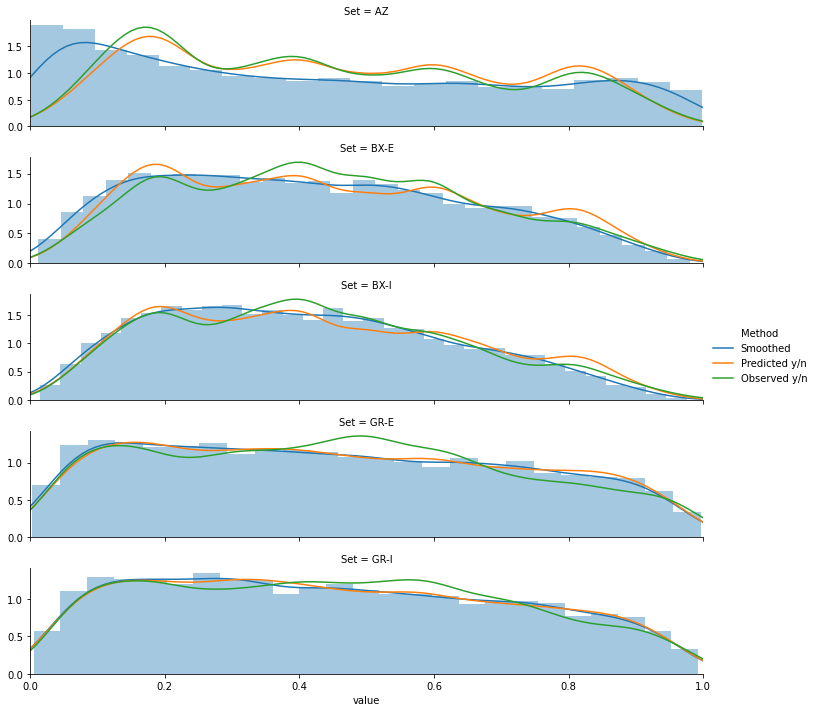

In [28]:
grid = sns.FacetGrid(all_prop.assign(hist=all_prop.Method == 'Observed y/n'), row='Set', hue='Method',
                     sharey=False, height=2, aspect=5)
for (r, c, h), df in grid.facet_data():
    if h == 0:
        sns.distplot(df['value'], kde=False, norm_hist=True, ax=grid.axes[r, c])
grid.map(sns.kdeplot, 'value', clip=(0,1)).add_legend()
plt.xlim(0, 1)
# plt.savefig(fig_dir / 'dist.pdf')

C:\Users\michaelekstrand\Anaconda3\envs\bookfair\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 8 x 6 in image.
C:\Users\michaelekstrand\Anaconda3\envs\bookfair\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: figures\PMA-profile\profile-dist.pdf


C:\Users\michaelekstrand\Anaconda3\envs\bookfair\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 8 x 6 in image.
C:\Users\michaelekstrand\Anaconda3\envs\bookfair\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: figures\PMA-profile\profile-dist.png


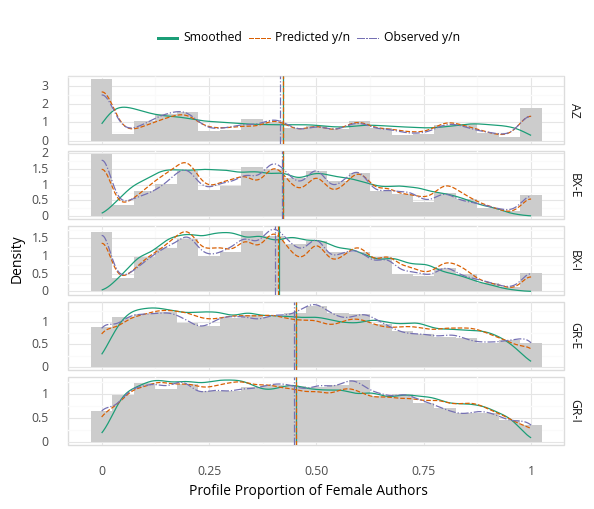

<ggplot: (-9223371864104079948)>

In [29]:
from bookgender.nbutils import make_plot
make_plot(all_prop, p.aes('value'),
          p.geom_histogram(p.aes(y='..density..'), data=obs_prop,
                           binwidth=0.05, fill='#CCCCCC'),
          p.geom_line(p.aes(color='Method', linetype='Method'),
                      stat='density', bw='scott', adjust=0.5),
          p.geom_vline(p.aes(xintercept='value', color='Method', linetype='Method'),
                       data=prop_means, show_legend=False),
          p.facet_grid('Set ~', scales='free_y'),
          p.scale_color_brewer('qual', 'Dark2'),
          p.xlab("Profile Proportion of Female Authors"),
          p.ylab("Density"),
          legend_position='top', legend_title=p.element_blank(),
          file='profile-dist', width=8, height=6)

## Robustness of Individual Inferences

The profiling process infers a $g(\theta_u)$ value for each user.  What is the variance of those estimates?

In [30]:
def u_stats(ds):
    ths = samples[ds]['nTheta'][...].T
    return pd.DataFrame({
        'mean': np.mean(ths, axis=1),
        'var': np.var(ths, axis=1),
        'lo': np.quantile(ths, 0.025, axis=1),
        'hi': np.quantile(ths, 0.975, axis=1)
    })
user_biases = pd.concat(dict(
    (ds, u_stats(ds)) for ds in datasets
), names=['Set', 'uidx'])
user_biases

mean       var        lo        hi
Set  uidx                                        
AZ   0     1.054401  0.859259 -0.700571  3.002711
     1    -0.934858  0.237320 -1.930807 -0.018967
     2    -2.654415  1.442534 -5.297968 -0.577858
     3    -1.526691  0.928144 -3.603834  0.212650
     4    -2.666763  1.462858 -5.313519 -0.560131
...             ...       ...       ...       ...
GR-I 4995  1.067249  0.002733  0.965943  1.169451
     4996 -1.541715  0.614372 -3.199276 -0.101126
     4997 -0.918005  0.050949 -1.365600 -0.494744
     4998  1.510707  0.035612  1.153674  1.886884
     4999 -2.026441  0.028055 -2.370763 -1.703400

[25000 rows x 4 columns]

C:\Users\michaelekstrand\Anaconda3\envs\bookfair\lib\site-packages\plotnine\stats\stat_bin.py:93: PlotnineWarning: 'stat_bin()' using 'bins = 85'. Pick better value with 'binwidth'.


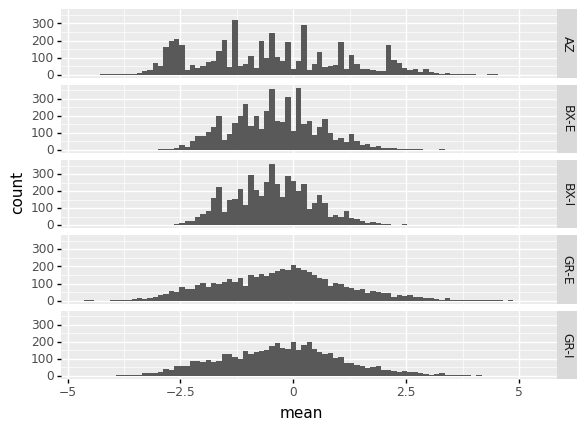

<ggplot: (-9223371864103765860)>

In [31]:
(p.ggplot(user_biases.reset_index(), p.aes('mean'))
 + p.geom_histogram()
 + p.facet_grid('Set ~'))

C:\Users\michaelekstrand\Anaconda3\envs\bookfair\lib\site-packages\plotnine\stats\stat_bin.py:93: PlotnineWarning: 'stat_bin()' using 'bins = 54'. Pick better value with 'binwidth'.


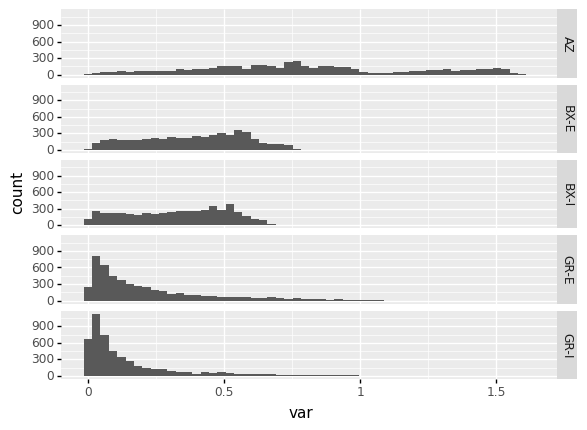

<ggplot: (-9223371864104392608)>

In [32]:
(p.ggplot(user_biases.reset_index(), p.aes('var'))
 + p.geom_histogram()
 + p.facet_grid('Set ~'))

This indicates quite a few $\theta_u$ values have high posterior variance, so we really do want to use the entire distribution.